# Process the ball info

In [ ]:
import cv2
import copy
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from torchvision.transforms import functional as F
import os
from src.tools.utils import write_json, clear_file, is_video_detect, find_next, find_reference
from src.tools.VideoClip import VideoClip
from src.models.PoseDetect import PoseDetect
from src.models.CourtDetect import CourtDetect
from src.models.NetDetect import NetDetect
import argparse
from src.tools.BallDetect import ball_detect
import warnings
# clear the polyfit Rankwarning
warnings.simplefilter('ignore', np.RankWarning)

result_path="C:/Users/86153/Desktop/res"
name_list=[
    "Akane_YAMAGUCHI_AN_Se_Young_BWF_World_Championships_2022_Semi_finals",
    "Akane_YAMAGUCHI_AN_Se_Young_DAIHATSU_YONEX_Japan_Open_2022_Finals",
    "Akane_YAMAGUCHI_CHEN_Yu_Fei_BWF_World_Championships_2022_Finals",
    "Akane_YAMAGUCHI_CHEN_Yu_Fei_England_Open_2022_Semi_finals",
    "An_Se_Young_Chen_Yu_Fei_PERODUA_Malaysia_Masters_2022_Finals",
    "AN_Se_Young_Gregoria_Mariska_TUNJUNG_Malaysia_Masters_2022_SemiFinals",
    "AN_Se_Young_Pornpawee_CHOCHUWONG_Korea_Open_Badminton_Championships_2022_Finals",
    "AN_Seyoung_PUSARLA_V",
    "Anders_Antonsen_Viktor_Axelsen_HSBC_BWF_WORLD_TOUR_FINALS_2020_Finals",
    "Anthony_Sinisuka_Ginting_Rasmus_Gemke_YONEX_Thailand_Open_2021_QuarterFinals",
]
for video_name in name_list:
    print("-" * 10 + "Starting Ball Detection" + "" * 10)       
    for res_root, res_dirs, res_files in os.walk(
            f"{result_path}/videos/{video_name}"):
        for res_file in res_files:
            _, ext = os.path.splitext(res_file)
            if ext.lower() in ['.mp4']:
                res_video_path = os.path.join(res_root, res_file)
                print(res_video_path)
                ball_detect(res_video_path, f"{result_path}/ball")
    print("" * 10 + "End Badminton Detection" + "" * 10)


In [ ]:
import torch

print(torch.__version__)

# Correct the wrong position information(deprecate)

In [ ]:
import cv2
import copy
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from torchvision.transforms import functional as F
import os
from src.tools.utils import write_json, read_json,clear_file, is_video_detect, find_next, find_reference
from src.tools.VideoClip import VideoClip
from src.models.PoseDetect import PoseDetect
from src.models.CourtDetect import CourtDetect
from src.models.NetDetect import NetDetect
import argparse
from src.tools.BallDetect import ball_detect
import warnings
# clear the polyfit Rankwarning
warnings.simplefilter('ignore', np.RankWarning)

result_path="E:\\res"
name_list=[
    "Akane_YAMAGUCHI_AN_Se_Young_BWF_World_Championships_2022_Semi_finals",
    "Akane_YAMAGUCHI_AN_Se_Young_DAIHATSU_YONEX_Japan_Open_2022_Finals",
    "Akane_YAMAGUCHI_CHEN_Yu_Fei_BWF_World_Championships_2022_Finals",
    "Akane_YAMAGUCHI_CHEN_Yu_Fei_England_Open_2022_Semi_finals",
    "An_Se_Young_Chen_Yu_Fei_PERODUA_Malaysia_Masters_2022_Finals",
    "AN_Se_Young_Gregoria_Mariska_TUNJUNG_Malaysia_Masters_2022_SemiFinals",
    "AN_Se_Young_Pornpawee_CHOCHUWONG_Korea_Open_Badminton_Championships_2022_Finals",
    "AN_Seyoung_PUSARLA_V__Sindhu_Korea_Open_Badminton_Championships_2022_Semi_Final",
    "Anders_Antonsen_Viktor_Axelsen_HSBC_BWF_WORLD_TOUR_FINALS_2020_Finals",
    "Anthony_Sinisuka_Ginting_Rasmus_Gemke_YONEX_Thailand_Open_2021_QuarterFinals",
]
print(result_path)
for video_name in name_list:
    print("" * 10 + "Starting Ball Detection" + "" * 10)       
    json_path=os.path.join(f"{result_path}/players/player_kp",f"{video_name}.json")
    print(json_path)
    # break

    info_dict=read_json(json_path)
    player_dict={}
    # 遍历 JSON 对象中的每个键值对
    for key, value in info_dict.items():
        # print(key)
        player_dict[key]={
            'top':value['bottom'],
            'bottom':value['top']
        }

        write_json(player_dict, video_name,f"E:/ans/players/player_kp")
        player_dict={}

    print(" " * 10 + "End Badminton Detection" + "+" * 10)


# Example Figure Draw

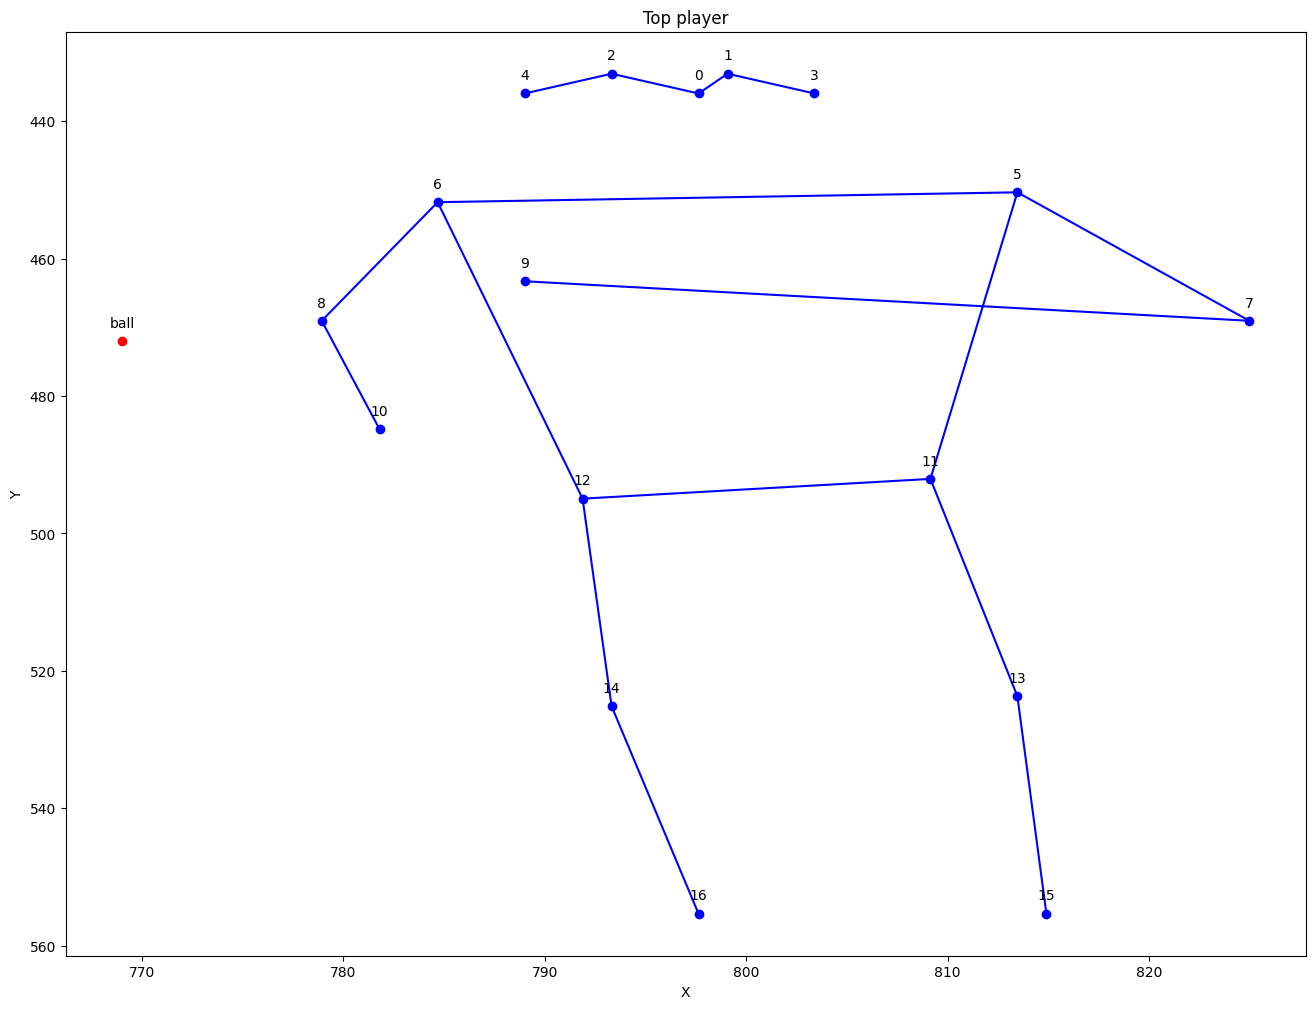

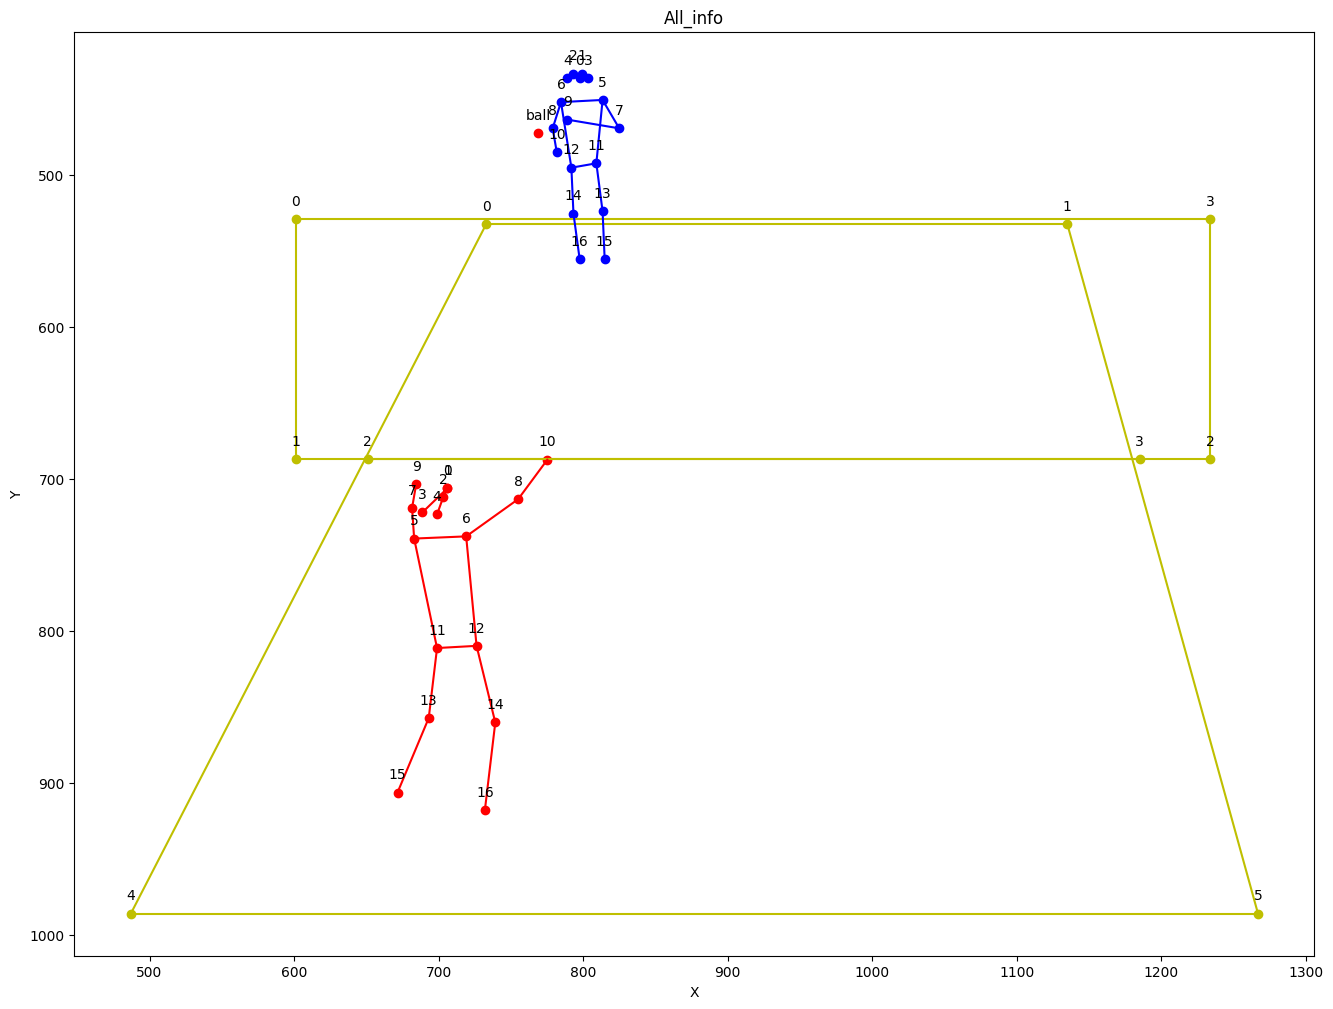

In [58]:
import cv2
import copy
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from torchvision.transforms import functional as F
import os
from src.tools.utils import write_json, read_json,clear_file, is_video_detect, find_next, find_reference
from src.tools.VideoClip import VideoClip
from src.models.PoseDetect import PoseDetect
from src.models.CourtDetect import CourtDetect
from src.models.NetDetect import NetDetect
import argparse
from src.tools.BallDetect import ball_detect
import warnings
# clear the polyfit Rankwarning
warnings.simplefilter('ignore', np.RankWarning)

players_dict = read_json("res/players/player_kp/test5.json")
ball_dict=read_json("res/ball/loca_info/test5/test5_0-298.json")
court_dict=read_json("res/courts/court_kp/test5.json")


current_frame=33
ball=(ball_dict[str(current_frame)]['x'],ball_dict[str(current_frame)]['y'])


# figure 1
plt.figure(figsize=(16, 12)) 
plt.gca().invert_yaxis()

# 给定的点
joints = players_dict[f"{current_frame}"]
players_joints = joints['top']

# 提取 x 坐标和 y 坐标
x = [joint[0] for joint in players_joints]
y = [joint[1] for joint in players_joints]


# 创建散点图
plt.scatter(x, y,c="b")

plt.scatter(ball[0], ball[1],c="r")
plt.annotate("ball", (ball[0], ball[1]), textcoords="offset points", xytext=(0,10), ha='center')


edges = [(0, 1), (0, 2), (2, 4), (1, 3), (6, 8), (8, 10), (11, 12),
         (5, 7), (7, 9), (5, 11), (11, 13), (13, 15), (6, 12),
         (12, 14), (14, 16), (5, 6)]

# 循环添加标号
for i, joint in enumerate(players_joints):
    plt.annotate(str(i), (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')

# 绘制连接线
for edge in edges:
    plt.plot([x[edge[0]], x[edge[1]]], [y[edge[0]], y[edge[1]]], 'b-')


# 设置图形标题和轴标签
plt.title('Top player')
plt.xlabel('X')
plt.ylabel('Y')

# 显示图形
plt.show()


# figure 2
plt.figure(figsize=(16, 12)) 
plt.gca().invert_yaxis()


court=court_dict['court_info']
# 提取 x 坐标和 y 坐标
x = [joint[0] for joint in court]
y = [joint[1] for joint in court]


# 创建散点图
plt.scatter(x, y,c="y")

edges = [(0, 1), (2, 3), (4, 5),(0,4),(1,5)]

# 循环添加标号
for i, joint in enumerate(court):
    plt.annotate(str(i), (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')

# 绘制连接线
for edge in edges:
    plt.plot([x[edge[0]], x[edge[1]]], [y[edge[0]], y[edge[1]]], 'y-')


net=court_dict['net_info']


# 提取 x 坐标和 y 坐标
x = [joint[0] for joint in net]
y = [joint[1] for joint in net]


# 创建散点图
plt.scatter(x, y,c="y")

edges = [(0, 1), (1, 2), (2, 3),(0,3)]

# 循环添加标号
for i, joint in enumerate(net):
    plt.annotate(str(i), (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')

# 绘制连接线
for edge in edges:
    plt.plot([x[edge[0]], x[edge[1]]], [y[edge[0]], y[edge[1]]], 'y-')



# 给定的点
joints = players_dict[f"{current_frame}"]
players_joints = joints['top']

# 提取 x 坐标和 y 坐标
x = [joint[0] for joint in players_joints]
y = [joint[1] for joint in players_joints]


# 创建散点图
plt.scatter(x, y,c="b")

plt.scatter(ball[0], ball[1],c="r")
plt.annotate("ball", (ball[0], ball[1]), textcoords="offset points", xytext=(0,10), ha='center')


edges = [(0, 1), (0, 2), (2, 4), (1, 3), (6, 8), (8, 10), (11, 12),
         (5, 7), (7, 9), (5, 11), (11, 13), (13, 15), (6, 12),
         (12, 14), (14, 16), (5, 6)]

# 循环添加标号
for i, joint in enumerate(players_joints):
    plt.annotate(str(i), (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')

# 绘制连接线
for edge in edges:
    plt.plot([x[edge[0]], x[edge[1]]], [y[edge[0]], y[edge[1]]], 'b-')

players_joints = joints['bottom']

# 提取 x 坐标和 y 坐标
x = [joint[0] for joint in players_joints]
y = [joint[1] for joint in players_joints]

# 创建散点图
plt.scatter(x, y,c="r")

edges = [(0, 1), (0, 2), (2, 4), (1, 3), (6, 8), (8, 10), (11, 12),
         (5, 7), (7, 9), (5, 11), (11, 13), (13, 15), (6, 12),
         (12, 14), (14, 16), (5, 6)]

# 循环添加标号
for i, joint in enumerate(players_joints):
    plt.annotate(str(i), (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')

# 绘制连接线
for edge in edges:
    plt.plot([x[edge[0]], x[edge[1]]], [y[edge[0]], y[edge[1]]], 'r-')


# 设置图形标题和轴标签
plt.title('All_info')
plt.xlabel('X')
plt.ylabel('Y')

# 显示图形
plt.show()


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# 创建一个无向图
G = nx.Graph()

# 添加边

G.add_edges_from(edges)

# 绘制图形
pos = nx.spring_layout(G)  # 设定节点布局
nx.draw(G, pos, with_labels=True, node_size=1000)  # 绘制图形
plt.show()  # 显示图形